Where is this code taken from? https://github.com/divyanshj16/GANs/blob/master/GANs-PyTorch.ipynb


## Setup

In [ ]:
from google.colab import drive
import os
drive.mount("/content/gdrive/")
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.utils as vutils

import numpy as np




import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray' #* change


def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        #ax = plt.subplot(gs[i])
        plt.axis('off')
        #ax.set_xticklabels([])
        #ax.set_yticklabels([])
        #ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
        plt.show()
    return 


def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

## Dataset 

In [ ]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples


batch_size = 128

image_size = 64 #total area of pixels 64*64 for training data so all input will be
#transformed to this dimension
root= '/content/gdrive/My Drive/CS464/CS464_project/code/arcDataset/filestruct' 
workers = 4

nc = 3 #channel size

ndf = 64 #feature map size for discriminator

# Size of z latent vector (size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

num_epochs = 100

lr = 0.0002 #learning rate

beta1 = 0.5 #for adam optimizers
ngpu = 1



dataset = dset.ImageFolder(root=root,
                           transform=T.Compose([T.Resize(image_size),T.CenterCrop(image_size), T.ToTensor(),T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])) #T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           #]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
imgs = next(iter(dataloader))


In [ ]:
#imgs = dataloader.__iter__().next()[0].view(batch_size,4096).numpy().squeeze()


In [ ]:
#show_images(imgs)

In [ ]:
def weights_init(m): #from vanilla
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Discriminator(nn.Module): #base model for all nn modules
    def __init__(self,ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu)

if (device.type == 'cuda') and (ngpu > 1): #at burayı
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.conv1 = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
losses = nn.BCELoss() #Inıtilaize BCE
#(we used binary cross entropy while measuring for losses because ) loss functions 

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

#what values we are gonna give to labels
real_label = 1
fake_label = 0

#same adam optimizers for sicriminator and generators
optimizerD = optim.Adam(netD.parameters(),lr=lr,betas=(beta1,0.999)) 
optimizerG = optim.Adam(netG.parameters(),lr=lr,betas=(beta1,0.999))


# Training a GAN!

Start training
[0/100][0/3]	Loss_D: 0.3209	Loss_G: 9.2822	D(x): 0.9289	D(G(z)): 0.1782 / 0.0001


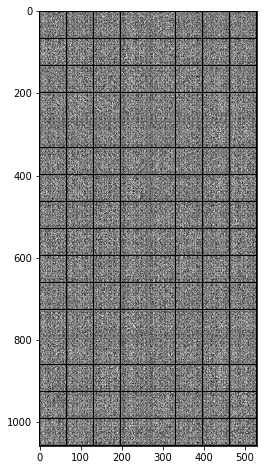

[1/100][0/3]	Loss_D: 0.1423	Loss_G: 9.2390	D(x): 0.9084	D(G(z)): 0.0092 / 0.0002
[2/100][0/3]	Loss_D: 0.1726	Loss_G: 8.5082	D(x): 0.8742	D(G(z)): 0.0173 / 0.0004
[3/100][0/3]	Loss_D: 0.0671	Loss_G: 7.2384	D(x): 0.9528	D(G(z)): 0.0123 / 0.0018
[4/100][0/3]	Loss_D: 0.1180	Loss_G: 12.7615	D(x): 0.9368	D(G(z)): 0.0001 / 0.0000
[5/100][0/3]	Loss_D: 0.0817	Loss_G: 11.0750	D(x): 0.9377	D(G(z)): 0.0094 / 0.0000
[6/100][0/3]	Loss_D: 0.4849	Loss_G: 16.9082	D(x): 0.9376	D(G(z)): 0.3030 / 0.0000
[7/100][0/3]	Loss_D: 2.0795	Loss_G: 23.8398	D(x): 0.9730	D(G(z)): 0.8197 / 0.0000
[8/100][0/3]	Loss_D: 0.0614	Loss_G: 16.2105	D(x): 0.9543	D(G(z)): 0.0000 / 0.0000
[9/100][0/3]	Loss_D: 0.2369	Loss_G: 24.8616	D(x): 0.8273	D(G(z)): 0.0000 / 0.0000
[10/100][0/3]	Loss_D: 0.0730	Loss_G: 6.9635	D(x): 0.9441	D(G(z)): 0.0032 / 0.0030
[11/100][0/3]	Loss_D: 0.2982	Loss_G: 22.4543	D(x): 0.7878	D(G(z)): 0.0000 / 0.0000
[12/100][0/3]	Loss_D: 1.8185	Loss_G: 21.6321	D(x): 0.9753	D(G(z)): 0.7702 / 0.0000
[13/100][0/3]	Los

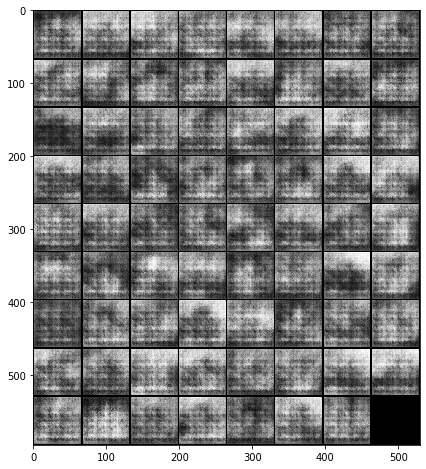

In [ ]:
# Lists to keep track of progress
imgsGenerated = []
G_losses = []
D_losses = []
iters = 0
flagg = 0

print("Start training")

for epoch in range(num_epochs): #for each epoch
  for i,data in enumerate(dataloader): #for each batch
    #Part 1 Update discrimnator network to maximize log(D(x)) + log(1-D(G(z)))
    #   A: train D network with real batch
    netD.zero_grad() #zero out gradients refresh
    real_batch = data[0].to(device) #pass batch to gpu to be trained with real data
    #print("real batch s",type(real_batch))
    b_size = real_batch.size(0)
    #print("bsize s",type(b_size))
    label_tensor = torch.full((b_size,),real_label,device=device) # a tensor of ones for grad descent
    #print("label s",type(label_tensor))
    out = netD(real_batch).view(-1)#pass forward on the batch and flatten
    #print("out s",type(out))
    d_real_error = losses(out,label_tensor) #calculate losses on real data
    d_real_error.backward() #backward pass calculate gradientes
    d_x = out.mean().item()

    #   B: train network D with fake images
    noise = torch.randn(real_batch.size(0),nz,1,1,device=device) #generate random noise
    fake_img = netG(noise) #generate fake_img from random noise
    label_tensor.fill_(fake_label) #fill the original disc label tensor with fake labels
    out = netD(fake_img.detach()).view(-1)#pass forward on the batch and flatten
    d_fake_error = losses(out,label_tensor) #calculate losses on fake data
    d_fake_error.backward()#backward pass calculate gradients
    dgz = out.mean().item()# generator mean error
    d_error_tot = d_real_error + d_fake_error #add the graidents from both real and fake
    optimizerD.step() #update D pass to Adam optimizer


    #Part 2 update generator network to maximize log(D(G(z))) 
    netG.zero_grad()#reset gradients
    label_tensor.fill_(real_label)#compare real labels with the fake output
    #we will perform another forwardpass from D with the fake batch
    out = netD(fake_img).view(-1)#* bak buna detach neden ikincisinde yok
    g_error= losses(out,label_tensor)#calculate gs loss
    g_error.backward()#calc graidents
    dgz2 = out.mean().item()
    optimizerG.step() #update G with Adam optimizer

    # Output training stats
    if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(dataloader),
                  d_error_tot.item(), g_error.item(), d_x, dgz, dgz2))

    # Save Losses for plotting later
    G_losses.append(g_error.item())
    D_losses.append(d_error_tot.item())


    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        with torch.no_grad():
            fake = netG(noise).detach().cpu()
        imgsGenerated.append(vutils.make_grid(fake, padding=2, normalize=True))
        
        namela = [t.numpy() for t in imgsGenerated]
        plt.imshow(namela[flagg][0])
        flagg += 1
        plt.show()
        

    iters += 1

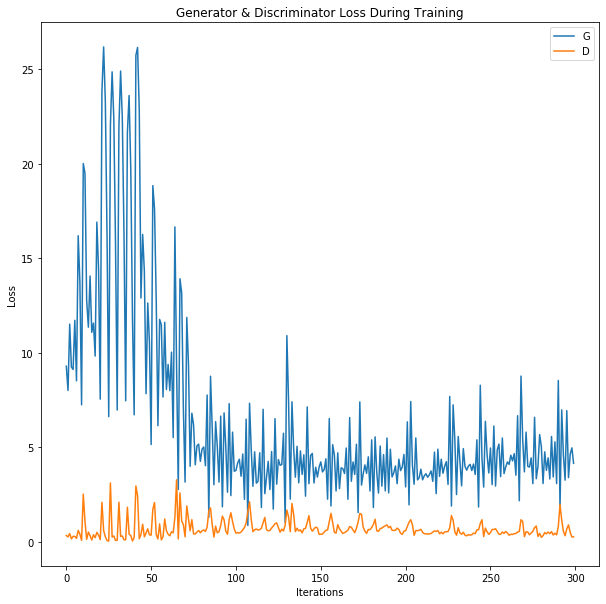

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Generator & Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label=
         "D")
plt.xlabel("Iterations")

plt.ylabel("Loss")
plt.legend()
plt.show()

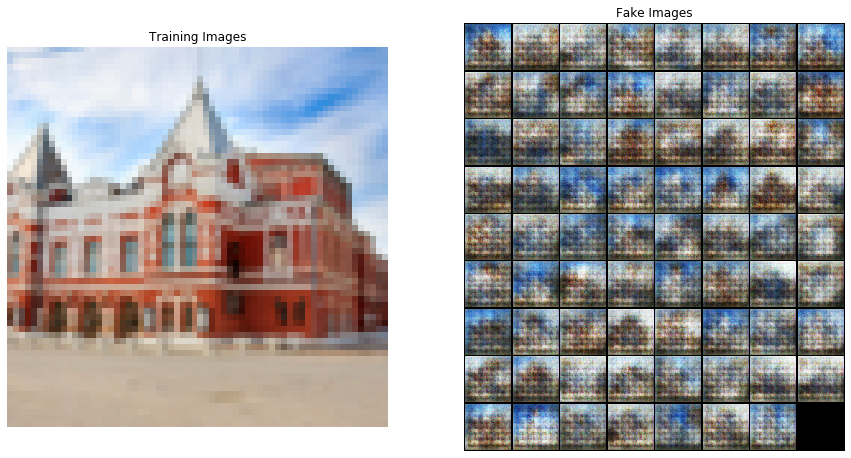

In [ ]:
# Grab a batch of real images from the dataloader

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(imgsGenerated[-1],(1,2,0)))
plt.show()